In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.sparse import diags
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
plt.rcParams.update({'font.size': 14})
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

#Creates a triangle function as initial distribution
def initf(x,Nx):
    mini = 1
    maxi = 2
    ini = np.zeros(Nx)
    for i in range(int(Nx/2)): 
        ini[i] = -(mini-maxi)/int(Nx/2)*i
        ini[i+int(Nx/2)] = (mini-maxi)/int(Nx/2)*i+mini
    ini /= sum(ini)*dx
    return ini#

def plotresult(x,c,Darray,drift,title):
    colorwave = cm.plasma(np.linspace(0, 1, Nt))
    fig=plt.figure(1, figsize = (15,5) )
    host = plt.subplot(1,2,1)
    par1 = host.twinx()
    color1 = 'orange'
    color2 = 'blue'
    host.set_xlabel('space x')
    host.set_ylabel('Drift', color=color1)
    par1.set_ylabel('Diffusion coefficient', color=color2)
    host.tick_params('y', colors=color1)
    par1.tick_params('y', colors=color2)
    p1 = host.plot(x,drift,color=color1)
    p2 = par1.plot(x,Darray,color=color2)
    plt.title('Initial conditions')
    
    ax2 = plt.subplot(1,2,2)
    for i in range(Nt):
        if i % 100 == 0:
            plt.plot(x,c[:,i],c=colorwave[i])
            plt.xlabel('space x')
            plt.ylabel('concentration c')
            plt.title(str(title))
    #plt.ylim([0,1.05*np.amax(c)])
    plt.title('Time evolution')
    plt.tight_layout()  
    plt.savefig(str(title)+'.svg', format='svg')
    plt.show()

def convection(nt, nx, delta_x, c):
    # Initialise data structures
    u = np.zeros((nx,nt))
    x = np.zeros(nx)

    # Initial conditions
    #for i in range(0,nx):
    #    #u[i,0] = 0#np.cos(omega*i*180/(nx*np.pi))
    #    if i < nx/4: u[i,0] = 1
    #    else: u[i,0] = 2
    #    if i > 3*nx/4: u[i,0] = 1
        
    mini = 1
    maxi = 2
    for i in range(int(nx/2)): 
        u[i,0] = -(mini-maxi)/int(nx/2)*i
        u[i+int(nx/2),0] = (mini-maxi)/int(nx/2)*i+mini
    u[:,0] /= sum(u[:,0])*delta_x            
    for i in range(0,nx): x[i] = i*delta_x       
    return u, x

def plot_convection(u_k,k):
    """
    Plots the 1D velocity field
    """
    plt.clf()
    plt.plot(x,u_k,'r')
    plt.xlabel('x (m)')
    plt.ylabel('u (m/s)')
    plt.ylim([np.nanmin(u)-0.1*abs(np.amax(u)),1.1*np.amax(u)])
    plt.title(f"Temperature at t = {k*dt:.3f} unit time")
    return plt

def plot_convection2(u,k,i,x):
    plt.plot(x,u[:,k],color=colorwave[i])
    plt.xlabel('x (m)')
    plt.ylabel('u (m/s)')
    plt.ylim([np.amin(u)-0.1,np.amax(u)+0.1])
    #plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    
def animate(k):
    plot_convection(u[:,k], k)
    
def CreateDarray(x,Nx):
    D0 = 1
    D1 = 2
    ini = np.zeros(Nx)
    for i in range(int(Nx/2)): 
        ini[i] = (D0-D1)/int(Nx/2)*i+D1
        ini[i+int(Nx/2)] = -(D0-D1)/int(Nx/2)*i+D0
    return ini#

# Idea to solve our equation

My idea to solve this equation is to transfer it to the following form:

### $\left [ D_{t}^{-}u=-D_{x}^{-}A\cdot u+ D_{x}^{-} B D_{x}^{+} \cdot u \right ]^{n}_{i}$

Perform the first forward derivative on the right side (and also the backward derivative in time on the left side). I use the product rule ($h\left ( x \right ) = f\left ( x \right ) \cdot g\left ( x \right )$; ${h}'\left ( x \right ) = {f}'\left ( x \right ) \cdot g\left ( x \right ) + f\left ( x \right ) \cdot {g}'\left ( x \right )$):

### $\frac{u_{i}^{n}-u_{i}^{n-1}}{\Delta t} = - \left ( \frac{A_{i+1}-A_{i}}{\Delta x} \cdot u_{i}^{n} + A_{i} \cdot \frac{u_{i+1}^{n}-u_{i}^{n}}{\Delta x} \right ) + D_{x}^{-} \cdot B_{i} \cdot \frac{u_{i+1}^{n}-u_{i}^{n}}{\Delta x} $

Now perform the first backward derivative on the right side:
### $\frac{u_{i}^{n}-u_{i}^{n-1}}{\Delta t} = - \left ( \frac{A_{i+1}-A_{i}}{\Delta x} \cdot u_{i}^{n} + A_{i} \cdot \frac{u_{i+1}^{n}-u_{i}^{n}}{\Delta x} \right ) + \frac{B_{i}-B_{i-1}}{\Delta x}  \cdot \frac{u_{i+1}^{n}-u_{i}^{n}}{\Delta x} + B_{i} \cdot \frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i+1}^{n}}{\Delta x^{2}} $

Rearrange for $-u_{i}^{n}$ and use the abbreviation $F = \frac{\Delta t}{\Delta x}$ and $G = \frac{\Delta t}{\Delta x^{2}}$:
### $\mathbf{-u_{i}^{n-1}=-{\color{Orange} u_{i}^{n}}-F\cdot \left[ {\color{Orange} A_{i+1}u_{i}^{n}}- {\color{Orange} A_{i}u_{i}^{n}}+{\color{DarkGreen} A_{i}u_{i+1}^{n}}-{\color{Orange} A_{i}u_{i}^{n}}\right ] } \\
\mathbf{+ G \cdot [ {\color{DarkGreen} B_{i}u_{i+1}^{n}} - {\color{Orange} B_{i}u_{i}^{n}} - {\color{DarkGreen} B_{i-1}u_{i+1}^{n}} + {\color{Orange} B_{i-1}u_{i}^{n}} + {\color{DarkGreen} B_{i}u_{i+1}^{n}} -{\color{Orange} 2B_{i}u_{i}^{n}} + {\color{Blue} B_{i}u_{i-1}^{n}} 
 ]  }
$

Multiply with -1 and reange the terms:
### $\mathbf{u_{i}^{n-1}= {\color{Orange} u_{i}^{n}} + F\cdot \left [ {\color{DarkGreen} u_{i+1}^{n} \cdot A_{i}} + {\color{Orange} u_{i}^{n} \cdot \left ( A_{i+1}-2A_{i} \right )} \right ] } \\
\mathbf{ - G \cdot  \left [ {\color{DarkGreen} u_{i+1}^{n}\cdot \left ( 2B_{i}-B_{i-1} \right )} 
+ {\color{Orange} u_{i}^{n}\cdot \left ( B_{i-1} - 3B_{i} \right )}
+ {\color{Blue} u_{i-1}^{n}\cdot B_{i} }
\right ] }$

Simplify:
### $\mathbf{u_{i}^{n-1}= {\color{Orange} u_{i}^{n} \left [ 1+F\left ( A_{i+1}-2A_{i} \right ) +G\left ( 3B_{i}-B_{i-1} \right )\right ]} } \\
\mathbf{ {\color{DarkGreen} + u_{i+1}^{n} \cdot  \left [ F\cdot A_{i}+G\left ( B_{i-1}-2B_{i} \right ) \right ]}} \\
\mathbf{{\color{Blue} - u_{i-1}^{n}\cdot G\cdot 2B_{i} }}
$
I use Naumann boundary conditions, that means that the derivative at the boundary equals a certain value

### $\frac{\mathrm{d}  u_{0}^{n}}{\mathrm{d} x} = C;\; \;  \; \; \; \; \frac{\mathrm{d}  u_{N_{x}}^{n}}{\mathrm{d} x} = D$

or in our case:

### $\frac{u_{1}^{n}-u_{0}^{n}}{\Delta x}=C; \; \; \; \; \; \; \frac{u_{N_{x}}^{n}-u_{N_{x}-1}^{n}}{\Delta x}=D.$

Which is equivalent to:

### $u_{0}^{n}-u_{1}^{n}=-C\Delta x; \; \; \; \; \; \; u_{N_{x}}^{n}-u_{N_{x}-1}^{n}=D\Delta x$


The resulting matrix would look like that (boundary conditions already included):
####  $
\begin{bmatrix}
 1 & -1  & 0 & 0 & 0 & 0\\
 G\cdot \left [ B_{i+1}-2B_{i} \right ] & 1+F\left ( A_{i+1}-2A_{i} \right ) +2G\left ( 3B_{i}-B_{i+1}- B_{i-1} \right ) & F\cdot A_{i}+G\left ( B_{i-1}-2B_{i} \right ) & 0 & 0 & 0\\
 0 & G\cdot \left [ B_{i+1}-2B_{i} \right ]  & 1+F\left ( A_{i+1}-2A_{i} \right ) +2G\left ( 3B_{i}-B_{i+1}- B_{i-1} \right ) & F\cdot A_{i}+G\left ( B_{i-1}-2B_{i} \right ) & 0 & 0\\
 0 & 0  & G\cdot \left [ B_{i+1}-2B_{i} \right ]  & 1+F\left ( A_{i+1}-2A_{i} \right ) +2G\left ( 3B_{i}-B_{i+1}- B_{i-1} \right ) & F\cdot A_{i}+G\left ( B_{i-1}-2B_{i} \right ) & 0\\
 0 & 0  & 0  &  G\cdot \left [ B_{i+1}-2B_{i} \right ] & 1+F\left ( A_{i+1}-2A_{i} \right ) +2G\left ( 3B_{i}-B_{i+1}- B_{i-1} \right ) & F\cdot A_{i}+G\left ( B_{i-1}-2B_{i} \right )\\
 0 & 0  & 0  &  0 &  -1 & 1\\
\end{bmatrix}
\begin{bmatrix}
0\\
u_{1}^{n}\\
u_{2}^{n}\\
u_{3}^{n}\\
u_{4}^{n}\\
0
\end{bmatrix}=
\begin{bmatrix}
-C \Delta x\\
u_{1}^{n-1}\\
u_{2}^{n-1}\\
u_{3}^{n-1}\\
u_{4}^{n-1}\\
D \Delta x
\end{bmatrix}
$

In [4]:
Nx = 200                     #x steps
Nt = 1000                    #t steps
L = 10                       #Length of the domain ([0,L])
T = 10                        #Stop time of the simulation
x = np.linspace(0, L, Nx)    #x space   
t = np.linspace(0, T, Nt)    #t space
dt = t[1]-t[0]               #t step
dx = x[1] - x[0]             #x step

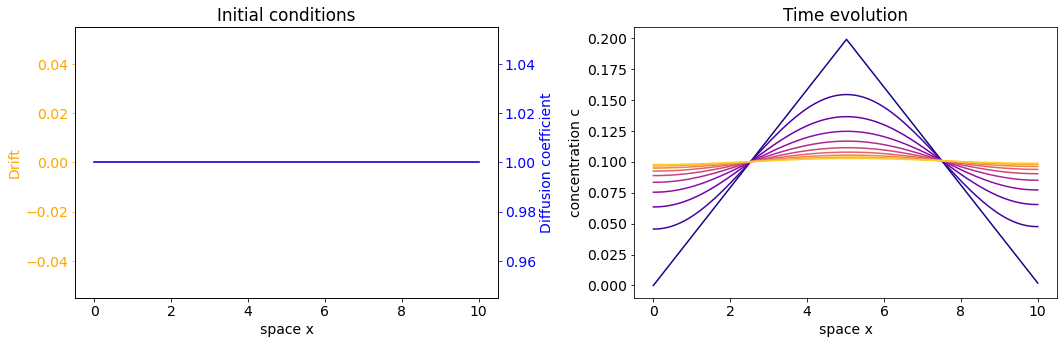

In [5]:
F = dt/dx
G = dt/dx**2

#Initial condition
inidensity = initf(x,Nx)#np.ones(Nx)/(Nx*dx)#
inidiff = np.ones(Nx)#np.linspace(0.5,0.51,Nx)#-initf(x,Nx)+0.5##Dini##Dini#
inidrift = np.zeros(Nx)#np.ones(Nx)#-Dini+2#-#np.linspace(2,1,Nx)#
A = inidrift
B = inidiff
Cini = inidensity

#Create the matrix M
M = np.zeros((Nx,Nx))
for i in range(1,Nx):
    if i < (Nx-1):
        M[i,i] = 1+F*(A[i+1]-2*A[i])+G*(3*B[i]-B[i-1])   
        M[i,i-1] = -G*B[i-1]        
    M[i-1,i] = F*A[i]+G*(B[i-1]-2*B[i])
M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
M[0,1] = M[-1,-2] = -1

#Solve the equation
c = np.zeros((Nx,Nt))        #array to save the density distributions
c[:,0] = Cini#np.ones(Nx)/(Nx*dx)#binitial#
for i in range(1,Nt):
    b = c[:,i-1].copy()
    b[0] = b[-1] = 0#b[1]
    c[:,i] = np.linalg.solve(M,b)
    #c[:,i] = c[:,i]/sum(abs(c[:,i])*dx)
    
plotresult(x,c,inidiff,inidrift,'Explicit Solution')

In [ ]:
#Animation
u = c  
name = 'Fokker-Planck'
anim = animation.FuncAnimation(plt.figure(), animate, interval=10, frames=Nt, repeat=False)
anim.save(str(name)+".mp4")
print("Done!")

## Time dependent

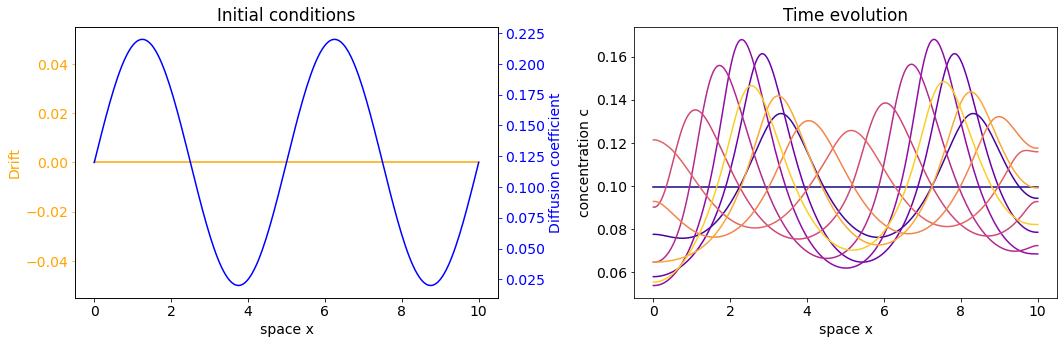

In [7]:
x2 = np.linspace(0,4*np.pi,Nx)
timea = np.linspace(0,T,Nt)
inidensity = np.ones(Nx)/(Nx*dx)#initf(x,Nx)#
inidiff = 0.1*(np.sin(x2) + 1.2)#np.ones(Nx)#np.linspace(0.5,0.51,Nx)#-initf(x,Nx)+0.5##Dini##Dini#
inidrift = np.zeros(Nx)#np.ones(Nx)#-Dini+2#-#np.linspace(2,1,Nx)#
A = inidrift
B = inidiff
Cini = inidensity

c = np.zeros((Nx,Nt))        #array to save the density distributions
c[:,0] = Cini#np.ones(Nx)/(Nx*dx)#binitial#
for i in range(1,Nt):
    B = 0.1*(np.sin(x2+timea[i]) + 1.2)
    M = np.zeros((Nx,Nx))
    for k in range(1,Nx):
        if k < (Nx-1):
            M[k,k] = 1+F*(A[k+1]-2*A[k])+G*(3*B[k]-B[k-1])   
            M[k,k-1] = -G*B[k-1]        
        M[k-1,k] = F*A[k]+G*(B[k-1]-2*B[k])
    M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
    M[0,1] = M[-1,-2] = -1

    b = c[:,i-1].copy()
    b[0] = b[-1] = 0#b[1]
    c[:,i] = np.linalg.solve(M,b)
    #c[:,i] = c[:,i]/sum(abs(c[:,i])*dx)
    
plotresult(x,c,inidiff,inidrift,'Explicit Solution')

Done!


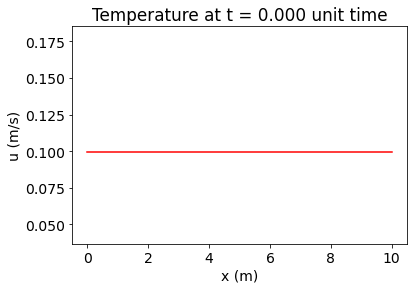

In [31]:
#Animation
u = c  
name = 'Fokker-Planck time dependent'
anim = animation.FuncAnimation(plt.figure(), animate, interval=10, frames=Nt, repeat=False)
anim.save(str(name)+".mp4")
print("Done!")